In [1]:
import cv2
import numpy as np
import glob
import json
import os
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import sys
import time
import random
random.seed(time.time())

sys.path.append(os.path.dirname(os.path.abspath('.')))
import utils.frame_slicing as frame_slicing
import utils.frame_concatent as frame_concatent

number_of_squares_x = 11
number_of_internal_corners_x = number_of_squares_x - 1
number_of_squares_y = 8
number_of_internal_corners_y = number_of_squares_y - 1
SQUARE_SIZE = 0.023 # in meters
cameras = ['cam2', 'cam3', 'wide', 'cam0', 'cam1']

In [2]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(10,9,0)
objp = np.zeros((number_of_internal_corners_x * number_of_internal_corners_y,3), np.float32)
objp[:,:2] = np.mgrid[0:number_of_internal_corners_x,0:number_of_internal_corners_y].T.reshape(-1,2)
objp = objp * SQUARE_SIZE

# Get image points
This function is used to get the image points of the chessboard. So the results can be reused during intrinsic calibration and extrinsic calibration.

Parameters:  
    None  
Return:  
    rets: array of boolean values, True if the chessboard is found, False otherwise shape (number of cameras, number of frames)  
    objpoints: array of image points shape (number of frames, number of cameras, number_of_internal_corners_x * number_of_internal_corners_y, 2)  
    shape: tuple of the shape of the image

In [3]:
def get_image_points():
    imgpoints = [] # 2D points in image plane
    objpoints = [] # 3D points in world coordinate system
    rets = [] # boolean values
    
    images = glob.glob('screen_shots/*.png')
    
    os.makedirs('chessboard_points', exist_ok=True)
    
    shape = (0,0)
    
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        frames = frame_slicing.slicing_frame(gray)[:5]
        
        frame_imgpoints = np.zeros((len(frames), number_of_internal_corners_x * number_of_internal_corners_y, 2))
        frame_objpoints = np.zeros((len(frames), number_of_internal_corners_x * number_of_internal_corners_y, 3))
        frame_rets = np.zeros(len(frames), dtype=bool) + True
        
        for i in range(len(frames)):
            frame = frames[i]
            shape = frame.shape
            
            ret, corners = cv2.findChessboardCorners(frame, (number_of_internal_corners_x,number_of_internal_corners_y), None)
            
            if ret == True:
                corners2 = cv2.cornerSubPix(frame, corners, (11,11), (-1,-1), criteria=criteria)
                frame_objpoints[i, :, :] = objp
                frame_imgpoints[i, :, :] = corners2[:, 0, :]
                
                cv2.drawChessboardCorners(frame, (number_of_internal_corners_x,number_of_internal_corners_y), corners2, ret)
                
            else:
                frame_rets[i] = False
                
        imgpoints.append(frame_imgpoints)
        objpoints.append(frame_objpoints)
        rets.append(frame_rets)
        
        frame_with_corners = frame_concatent.concatent_frame(frames)
        cv2.imwrite(f'chessboard_points/{fname.split("/")[-1]}', frame_with_corners)
        
    imgpoints = np.array(imgpoints)
    objpoints = np.array(objpoints)
    rets = np.array(rets)
    
    os.makedirs('results', exist_ok=True)
        
    if rets.sum() == 0:
        print('No chessboard found in any image')
        return
    
    with open('results/rets.json', 'w') as f:
        json.dump(rets.tolist(), f)
    with open('results/object_points.json', 'w') as f:
        json.dump(objpoints.tolist(), f)
    with open('results/image_points.json', 'w') as f:
        json.dump(imgpoints.tolist(), f)
    with open('results/shape.json', 'w') as f:
        json.dump(shape, f)

In [4]:
def intrinsic_calibration(cameras):
    with open('results/rets.json', 'r') as f:
        rets = np.array(json.load(f))
    with open('results/object_points.json', 'r') as f:
        objpoints = np.array(json.load(f))
    with open('results/image_points.json', 'r') as f:
        imgpoints = np.array(json.load(f))
    with open('results/shape.json', 'r') as f:
        shape = tuple(json.load(f))
    
    for camera_name in cameras:
        imgpoints_camera = imgpoints[:, cameras.index(camera_name), :, :]
        objpoints_camera = objpoints[:, cameras.index(camera_name), :, :]
        rets_camera = rets[:, cameras.index(camera_name)]
        imgpoints_camera = imgpoints_camera[rets_camera, :, :]
        objpoints_camera = objpoints_camera[rets_camera, :, :]
        
        number_of_images = len(rets_camera)
        number_of_success_images = np.sum(rets_camera.astype(int))
        
        obj_pts = []
        img_pts = []
        for i in range(number_of_success_images):
            obj_pts.append(objpoints_camera[i, :, :].astype(np.float32))
            img_pts.append(imgpoints_camera[i, :, :].astype(np.float32))
            
        obj_pts = np.array(obj_pts)
        img_pts = np.array(img_pts)        
        
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pts, img_pts, shape[::-1], None, None)
        
        with open(f'results/intrinsic_{camera_name}.json', 'w') as f:
            json.dump({'mtx': mtx.tolist(), 'dist': dist.tolist()}, f)
        
        print(f'{camera_name} has {number_of_success_images}/{number_of_images} successful images')
        
        mean_error = 0
        for i in range(number_of_success_images):
            imgpoints2, _ = cv2.projectPoints(obj_pts[i], rvecs[i], tvecs[i], mtx, dist)
            # Reshape imgpoints2 to match img_pts dimensions
            imgpoints2 = imgpoints2.reshape(-1, 2)
            error = cv2.norm(img_pts[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
            mean_error += error
        mean_error = mean_error / number_of_success_images
        print(f'{camera_name} has mean error: {mean_error}')
            
    return

# Project arrows into the image

In [5]:
axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)
axis = axis * SQUARE_SIZE

def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel().astype("int32"))
    imgpts = imgpts.astype("int32")
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

def projection(img, mtx, dist):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (number_of_internal_corners_x, number_of_internal_corners_y), None)
    if ret == True:
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria=criteria)
        ret,rvecs, tvecs = cv2.solvePnP(objp, corners2, mtx, dist)
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
        img = draw(img, corners2, imgpts)
        
    return img

def arrow_projection():
    mtxs = {}
    dists = {}
    for camera_name in cameras:
        with open(f'results/intrinsic_{camera_name}.json', 'r') as f:
            data = json.load(f)
            mtx = np.array(data['mtx'])
            dist = np.array(data['dist'])
            mtxs[camera_name] = mtx
            dists[camera_name] = dist
            
    fig = plt.figure(figsize=(20, 25))

    for i in range(5):
        images = os.listdir('screen_shots')
        random_index = random.randint(0, len(images) - 1)
        image = cv2.imread(f'screen_shots/{images[random_index]}')
        ax = fig.add_subplot(5, 2, i * 2 + 1)
        ax.imshow(image)
        ax.set_title(f'Before calibration')
        ax.axis('off')
        
        frames = frame_slicing.slicing_frame(image)[:5]
        
        for camera_name in cameras:
            frame_index = cameras.index(camera_name)
            frame = frames[frame_index] 
            h,  w = frame.shape[:2]
            newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtxs[camera_name], dists[camera_name], (w,h), 1, (w,h))
            dst = cv2.undistort(frame, mtxs[camera_name], dists[camera_name], None, newcameramtx)
            x, y, w, h = roi
            frame = projection(dst, mtxs[camera_name], dists[camera_name])
            frames[frame_index] = frame[y:y+h, x:x+w]
        
        images_after_calibration = frame_concatent.concatent_frame(frames)
        ax = fig.add_subplot(5, 2, i * 2 + 2)
        ax.imshow(images_after_calibration)
        ax.set_title(f'After calibration')
        ax.axis('off')
            
    plt.show()

# Pipeline-Intrinsic

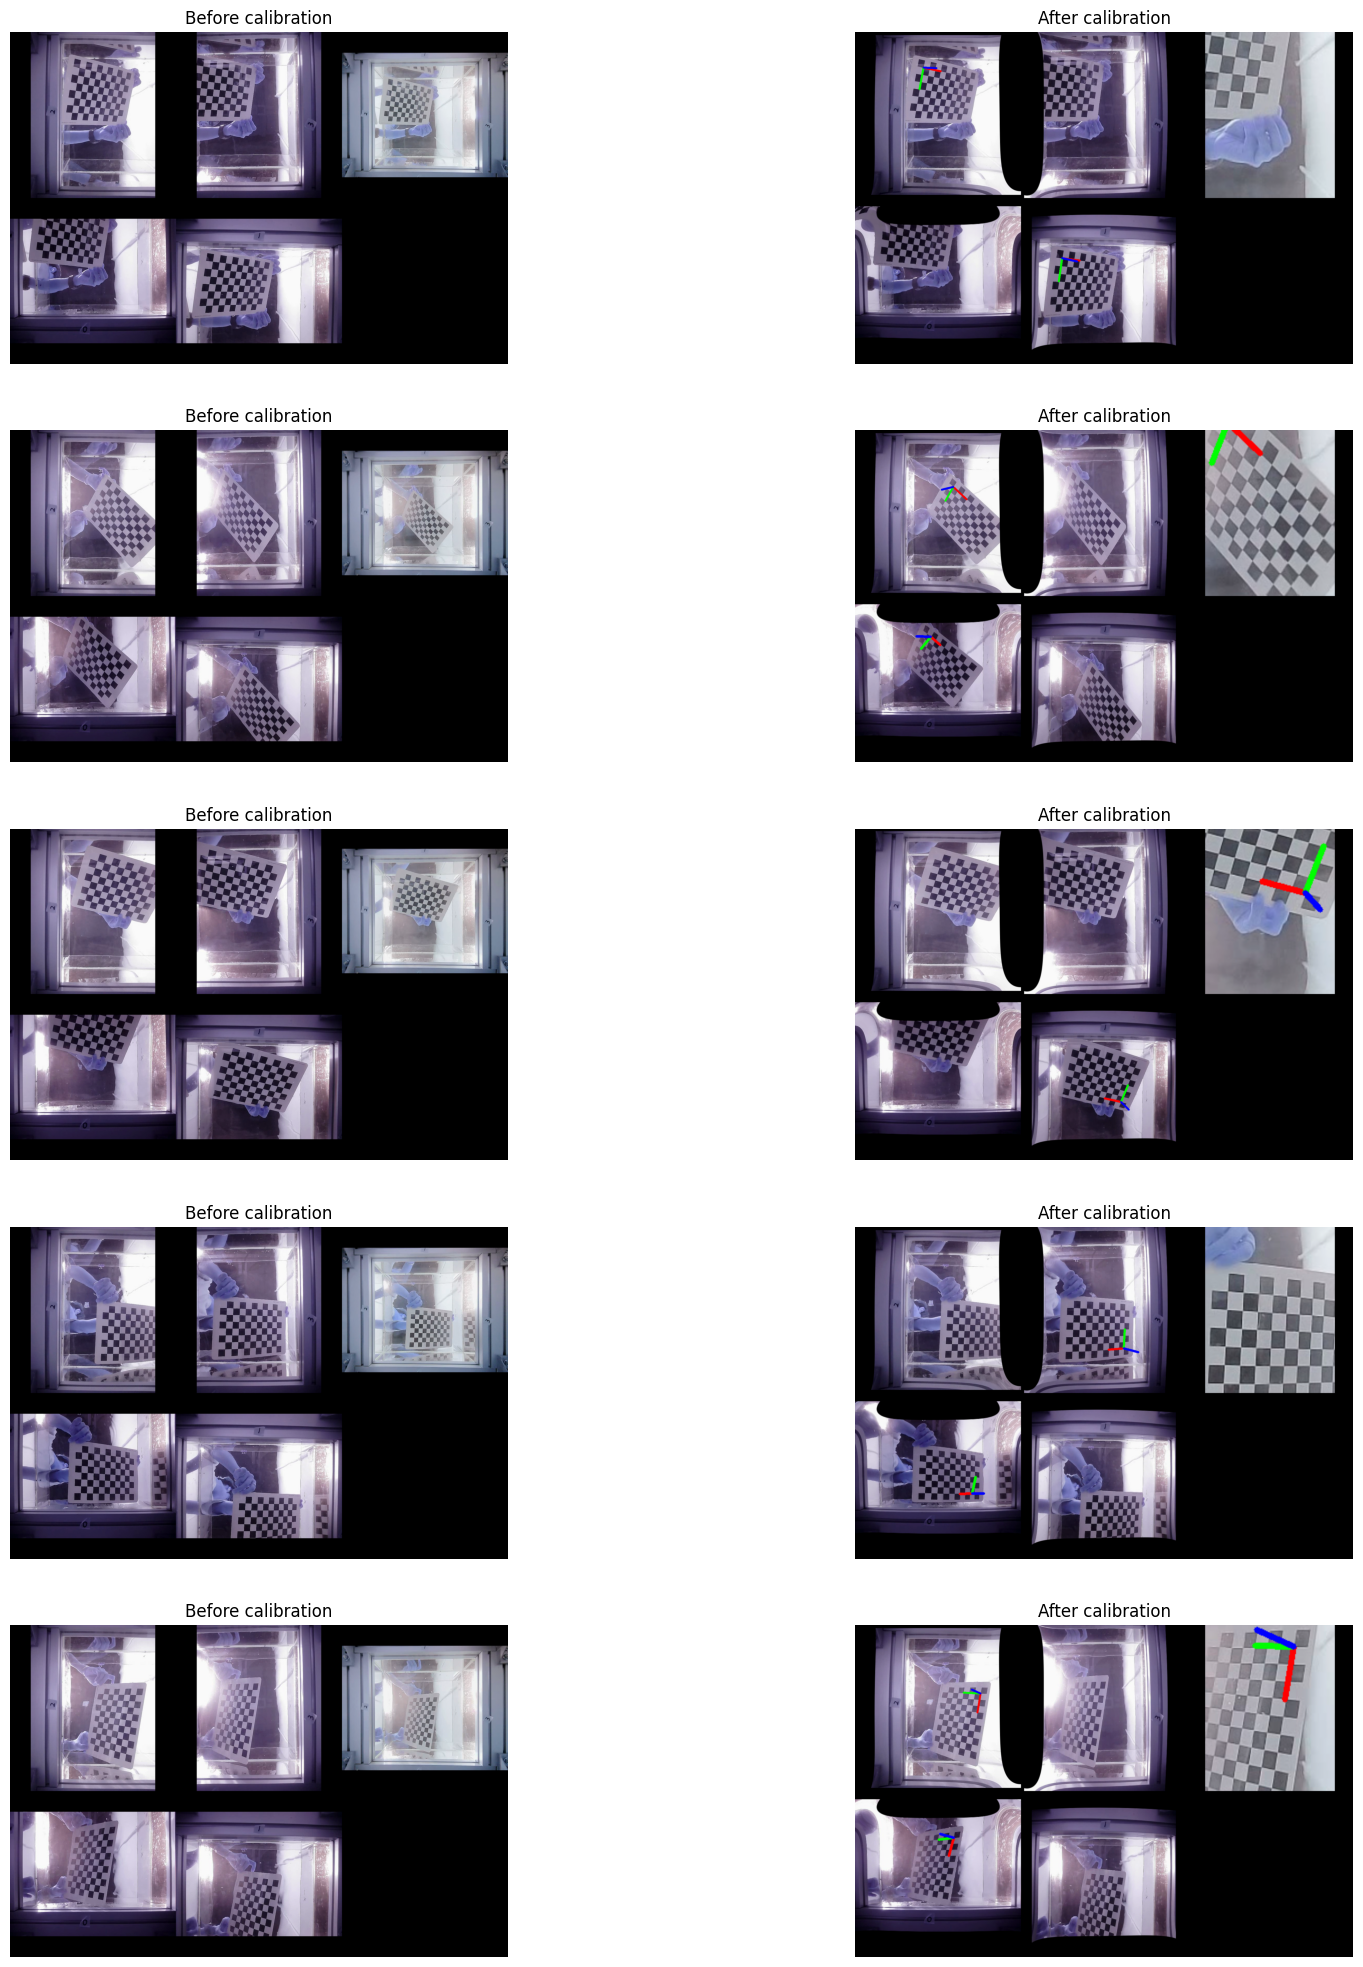

In [6]:
if os.path.exists('results/rets.json') and os.path.exists('results/object_points.json') and os.path.exists('results/image_points.json') and os.path.exists('results/shape.json'):
    pass
else:
    get_image_points()
        
results = os.listdir('results')
if 'intrinsic_cam0.json' in results and 'intrinsic_cam1.json' in results and 'intrinsic_cam2.json' in results and 'intrinsic_cam3.json' in results and 'intrinsic_wide.json' in results:
    pass
else:
    intrinsic_calibration(cameras)
    
arrow_projection()

# Extrinsic calibration

### Transformation Matrix

$$ H = \begin{bmatrix} R & t \\ 0 & 1 \end{bmatrix} 
    = \begin{bmatrix} r_{11} & r_{12} & r_{13} & t_x \\ r_{21} & r_{22} & r_{23} & t_y \\ r_{31} & r_{32} & r_{33} & t_z \\ 0 & 0 & 0 & 1 \end{bmatrix}
$$

In [7]:
def extrinsic_calibration():
    with open('results/rets.json', 'r') as f:
        rets = np.array(json.load(f))
    with open('results/object_points.json', 'r') as f:
        objpoints = np.array(json.load(f))
    with open('results/image_points.json', 'r') as f:
        imgpoints = np.array(json.load(f))
    with open('results/shape.json', 'r') as f:
        shape = tuple(json.load(f))
    mtxs = {}
    dists = {}
    for camera_name in cameras:
        with open(f'results/intrinsic_{camera_name}.json', 'r') as f:
            data = json.load(f)
            mtx = np.array(data['mtx'])
            dist = np.array(data['dist'])
            mtxs[camera_name] = mtx
            dists[camera_name] = dist
    
    for camera_name in cameras:
        transformation_matrix = np.eye(4)
        if camera_name == 'wide':
            pass
        else:
            stereo_objpoints = []
            stereo_imgpoints1 = []
            stereo_imgpoints2 = []
            for i in range(len(objpoints)):
                if rets[i, cameras.index(camera_name)] and rets[i, cameras.index('wide')]:
                    stereo_objpoints.append(objpoints[i, cameras.index(camera_name), :, :].astype(np.float32))
                    stereo_imgpoints1.append(imgpoints[i, cameras.index(camera_name), :, :].astype(np.float32))
                    stereo_imgpoints2.append(imgpoints[i, cameras.index('wide'), :, :].astype(np.float32))
            stereo_objpoints = np.array(stereo_objpoints)
            stereo_imgpoints1 = np.array(stereo_imgpoints1)
            stereo_imgpoints2 = np.array(stereo_imgpoints2)
            
            flags = (cv2.CALIB_FIX_INTRINSIC)
            results = cv2.stereoCalibrate(objectPoints=stereo_objpoints, imagePoints1=stereo_imgpoints1, imagePoints2=stereo_imgpoints2,
                                        cameraMatrix1=mtxs[camera_name], distCoeffs1=dists[camera_name], cameraMatrix2=mtxs['wide'], 
                                        distCoeffs2=dists['wide'], imageSize=shape, 
                                        flags=flags)
            R = results[5]
            T = results[6]
            transformation_matrix[:3, :3] = R
            transformation_matrix[:3, 3] = T[:3, 0]
        
        print(f'{camera_name} has {len(stereo_objpoints)} successful images')
        print(f'{camera_name} transformation matrix: {transformation_matrix}')
        
        with open(f'results/extrinsic_{camera_name}.json', 'w') as f:
            json.dump(transformation_matrix.tolist(), f)
    

In [8]:
def visualize(fig, elev, azim, roll, i):
    transformation_matrices = {}
    for camera_name in cameras:
        with open(f'results/extrinsic_{camera_name}.json', 'r') as f:
            transformation_matrix = np.array(json.load(f))
            transformation_matrices[camera_name] = transformation_matrix
            
    ax = fig.add_subplot(2, 3, i, projection='3d', elev=elev, azim=azim, roll=roll)
    length = 0.5
    width = 0.5
    height = 0.5
    
    x = [-length/2, length/2, length/2, -length/2]
    y = [-width/2, -width/2, width/2, width/2]
    for i in range(4):
        ax.plot([x[i], x[i]], [y[i], y[i]], [0, height], 'b-')
        
    x = [-length/2, length/2, length/2, -length/2]
    z = [0, 0, height, height]
    for i in range(4):
        ax.plot([x[i], x[i]], [-width/2, width/2], [z[i], z[i]], 'b-')
        
    y = [-length/2, length/2, length/2, -length/2]
    z = [0, 0, height, height]
    for i in range(4):
        ax.plot([-length/2, length/2], [y[i], y[i]], [z[i], z[i]], 'b-')
    
    for camera_name in cameras:
        colors = ['red', 'green', 'blue']
        axis = np.eye(3) * SQUARE_SIZE
        for i in range(3):
            orientation = transformation_matrices[camera_name][:3, :3] @ axis[i, :]
            x = transformation_matrices[camera_name][0, 3]
            y = transformation_matrices[camera_name][1, 3]
            z = transformation_matrices[camera_name][2, 3]
            u = orientation[0]
            v = orientation[1]
            w = orientation[2]
            ax.quiver(x, y, z, u, v, w, color = colors[i], length=1)
            
            if i == 0:
                ax.text(x, y, z, camera_name, color = 'black')
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

# Pipeline-Extrinsic

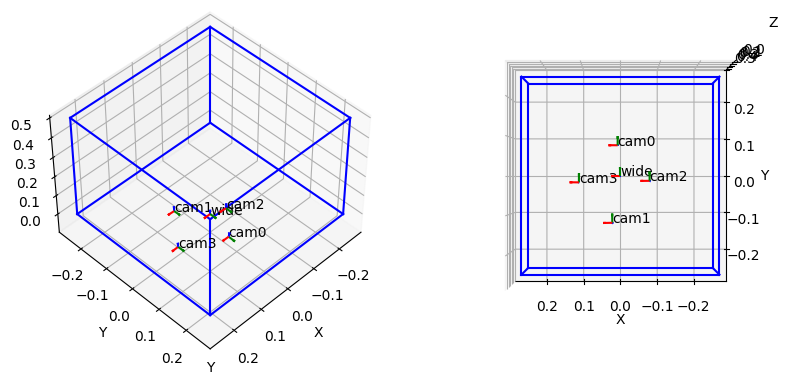

In [9]:
if os.path.exists('results/extrinsic_cam0.json') and os.path.exists('results/extrinsic_cam1.json') and os.path.exists('results/extrinsic_cam2.json') and os.path.exists('results/extrinsic_cam3.json') and os.path.exists('results/extrinsic_wide.json'):
    pass
else:
    extrinsic_calibration()

fig = plt.figure(figsize=(15, 10))
visualize(fig, 45, 0, 0, i=1)
visualize(fig, elev=45, azim=45, roll=0, i=1)
visualize(fig, elev=-90, azim=90, roll=0, i=2)
plt.show()